# Parser results -- Maltparser, default settings

This notebook will perform the same experiments as [the previous one](/notebooks/4.%20Analysis%20of%20parser%20results%20%28Mate%20tools%29.ipynb) for Mate tools, only instead using Maltparser run with default settings. We are also testing the entire UD 1.1 collection, instead of just looking at 1.0 as for Mate.

## Preprocessing

The conllu files had to be preprocessed to support the conllx format. This was done using the `tools/conllu2conllx.py` script. Thereafter the models were trained and tested with `tools/train_maltparser_default.py` and `tools/test_maltparser_default.py`.

#### Functional and content dependents
As specified in [A manual classification of dependency relations](/notebooks/3.%20A%20manual%20classification%20of%20dependency%20relations.ipynb)

- Functional dependents
- Content dependendents

#### Dependent classes as specified in the [UD documentation](http://universaldependencies.github.io/docs/u/dep/index.html)

- Classes expected to perform better than overall LAS for __synthetic__ languages:
  - __Core dependents of clausal predicates__: nsubj, csubj, nsubjpass, csubjpass, dobj, ccomp, xcomp, iobj
  - __Non-core dependents of clausal predicates__: nmod, advcl, advmod, neg
  - __Noun dependents, excluding _det_ and _neg___: nummod, acl, amod, appos, nmod
  - __Coordination, excluding _cc_ and _punct___: conj
  - 
- Classes expected to perform better than overall LAS for __isolated__ languages:
  - __Special clausal dependents__: vocative, aux, mark, discourse, auxpass, punct, expl, cop
  - __Case-marking, prepositions, possessive__: case


## Things to keep in mind when looking at the results

- Irish and Hungarian has fairly little data, and can't probably be trusted. 
- Czech has A LOT of data.

In [1]:
# Matplotlib
%matplotlib inline
import matplotlib
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 7.0)
matplotlib.style.use('ggplot')

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import sys, os
from os.path import join
sys.path.append("../tools/")
from collections import defaultdict

# Data management libraries
import pandas as pd
import seaborn as sns

# Treebank utils, found in "../tools"
import udeval, lang_utils, dependency_classes

is_labeled = True
is_fine_grained_deprels = True
file_format = "conllx"
test_type = "test"

system_output_base = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/baseline-UD/"
gold_output_base = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/universaldependencies1-1/ud-treebanks-v1.1/"
file_prefix = "matetools"

system_files = {"en": "en-en.all.conll.conllu",
                 "cs": "cs-cs.all.conll.conllu",
                 "de": "de-de.all.conll.conllu",
                 "en": "en-en.all.conll.conllu",
                 "es": "es-es.all.conll.conllu",
                 "fi": "fi-fi.all.conll.conllu",
                 "fr": "fr-fr.all.conll.conllu",
                 "ga": "ga-ga.all.conll.conllu",
                 "hu": "hu-hu.all.conll.conllu",
                 "it": "it-it.all.conll.conllu",
                 "sv": "sv-sv.all.conll.conllu"}

system_files = {x: join(system_output_base, y) for x,y in system_files.items()}
gold_files = lang_utils.get_ud_paths(gold_output_base, type_=test_type, format_=file_format)

def labeled_attachment_scores():
    las = {}
    for lang, system_path in system_files.items():
        s_out = system_path
        g_out = gold_files[lang_utils.code2lang[lang]]
        score = udeval.attachment_score(s_out, g_out, labeled=is_labeled, fine_grained_deprels=is_fine_grained_deprels)
        las[lang_utils.code2lang[lang]] = score
    return pd.Series(las)

def precision_recall_filter_labels(labels):
    prec_recs = {"precision": [], "recall": []}
    index = []
    for lang, system_path in system_files.items():
        s_out = system_path
        g_out = gold_files[lang_utils.code2lang[lang]]
        precision, recall = udeval.labels_precision_recall(s_out, 
                                                           g_out, 
                                                           labels=labels,
                                                           fine_grained_deprels=is_labeled)
        index.append(lang_utils.code2lang[lang])
        prec_recs["precision"].append(precision)
        prec_recs["recall"].append(recall)

    return pd.DataFrame(prec_recs, index=index).sort_values("precision")

TypeError: get_ud_paths() missing 1 required positional argument: 'coarse'

In [ ]:
las = labeled_attachment_scores()
las.to_csv('../data/' + file_prefix + '.las.csv')
las

In [25]:
all_labels_results = precision_recall_filter_labels(dependency_classes.all_labels)
all_labels_results

,precision,recall
Italian,0.047081,0.047081
Hungarian,0.700000,0.700000
Irish,0.732043,0.732043
German,0.793726,0.793726
French,0.808357,0.808357
Swedish,0.818414,0.818414
Czech,0.840810,0.840810
Spanish,0.840926,0.840926
Finnish,0.843685,0.843685
English,0.856269,0.856269


# Performance for dependency classes

We calculate the precision and recall only using the labels classified as content relations. We then subtract the LAS to present how large of an increase (or reduction) in results the label class gets.

### Content and function relations

#### Absolute performance

In [26]:
content_dependents_result = precision_recall_filter_labels(dependency_classes.content_dependents)
function_dependents_result = precision_recall_filter_labels(dependency_classes.function_dependents)
nonsemantic_dependents_result = precision_recall_filter_labels(dependency_classes.nonsemantic_dependents)
results_dict = {"Content": content_dependents_result, 
                "Function": function_dependents_result,
                "Nonsemantic": nonsemantic_dependents_result}

content_function_results = pd.concat(results_dict.values(), keys=results_dict.keys(), axis=1)

In [37]:
content_function_results.to_csv('../data/' + file_prefix + '.content_function_deprels.las.csv')
content_function_results

Nonsemantic             Content            Function          
            precision    recall precision    recall precision    recall
Czech        0.810497  0.810497  0.861259  0.861259  0.802592  0.802592
English      0.788934  0.788934  0.831739  0.831739  0.933500  0.933500
Finnish      0.827863  0.827863  0.837585  0.837585  0.884587  0.884587
French       0.684685  0.684685  0.783930  0.783930  0.878344  0.878344
German       0.697636  0.697636  0.744235  0.744235  0.910727  0.910727
Hungarian    0.470732  0.470732  0.682286  0.682286  0.890435  0.890435
Irish        0.798469  0.798469  0.633013  0.633013  0.870968  0.870968
Italian      0.018634  0.018634  0.031311  0.031311  0.071823  0.071823
Spanish      0.740700  0.740700  0.789924  0.789924  0.928190  0.928190
Swedish      0.753568  0.753568  0.788949  0.788949  0.887048  0.887048

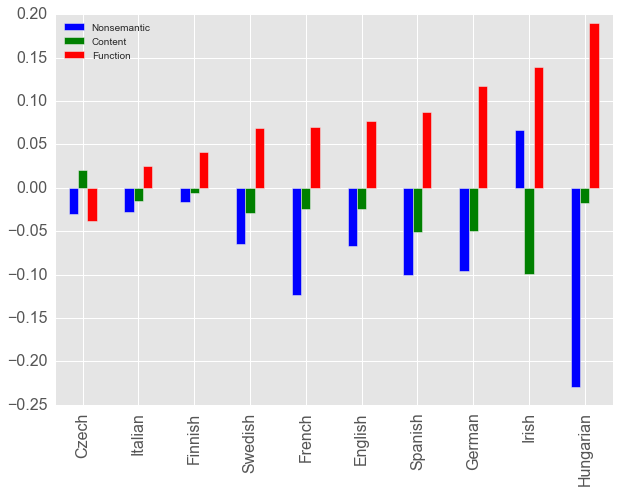

In [28]:
content_function_precisions = content_function_results.subtract(all_labels_results, level=1).xs('precision', level=1, axis=1)
content_function_precisions.sort_values('Function').plot(kind='bar', fontsize=16)

# What does this actually tell us?

Nothing, really, so far. Finnish might perform well on the few function relations it actually has. We need to look into function relations given how often they occur in the output. This is to be done in a later notebook.

In [31]:
core_dependent_result = precision_recall_filter_labels(dependency_classes.core_dependents)
noncore_dependents_result = precision_recall_filter_labels(dependency_classes.noncore_dependents)
noun_dependents_result = precision_recall_filter_labels(dependency_classes.noun_dependents)
coordination_dependents_result = precision_recall_filter_labels(dependency_classes.coordination_dependents)
special_clausal_dependents_result = precision_recall_filter_labels(dependency_classes.special_clausal_dependents)
other_functional_dependents_result = precision_recall_filter_labels(dependency_classes.other_functional_dependents)

ud_result_dict = {'Core': core_dependent_result,
                  'Noncore': noncore_dependents_result,
                  'Noun': noun_dependents_result,
                  'Coordination': coordination_dependents_result,
                  'Special clausal': special_clausal_dependents_result,
                  'Functionals': other_functional_dependents_result}

ud_class_result = pd.concat(ud_result_dict.values(), keys=ud_result_dict.keys(), axis=1)
ud_class_result

Special clausal             Noncore           Coordination  \
                precision    recall precision    recall    precision   
Czech            0.844505  0.844505  0.828885  0.828885     0.782097   
English          0.847275  0.847275  0.817923  0.817923     0.771600   
Finnish          0.841311  0.841311  0.801690  0.801690     0.807489   
French           0.738403  0.738403  0.774648  0.774648     0.696664   
German           0.755683  0.755683  0.735621  0.735621     0.722652   
Hungarian        0.509677  0.509677  0.693694  0.693694     0.546022   
Irish            0.789963  0.789963  0.598958  0.598958     0.657102   
Italian          0.014757  0.014757  0.023569  0.023569     0.014085   
Spanish          0.803213  0.803213  0.791529  0.791529     0.708640   
Swedish          0.820846  0.820846  0.755175  0.755175     0.742919   

                    Functionals                Core                Noun  \
             recall   precision    recall precision    recall precision   
Czech      0.782097    0.775428  0.775428  0.865753  0.865753  0.833281   
English    0.771600    0.936778  0.936778  0.903242  0.903242  0.875331   
Finnish    0.807489    0.886076  0.886076  0.881720  0.881720  0.851083   
French     0.696664    0.888787  0.888787  0.833713  0.833713  0.869758   
German     0.722652    0.929804  0.929804  0.686353  0.686353  0.851920   
Hungarian  0.546022    0.898167  0.898167  0.842444  0.842444  0.867327   
Irish      0.657102    0.885714  0.885714  0.614391  0.614391  0.748697   
Italian    0.014085    0.088004  0.088004  0.007682  0.007682  0.066395   
Spanish    0.708640    0.934152  0.934152  0.820513  0.820513  0.888815   
Swedish    0.742919    0.882175  0.882175  0.809412  0.809412  0.839250   

                     
             recall  
Czech      0.833281  
English    0.875331  
Finnish    0.851083  
French     0.869758  
German     0.851920  
Hungarian  0.867327  
Irish      0.748697  
Italian    0.066395  
Spanish    0.888815  
Swedish    0.839250

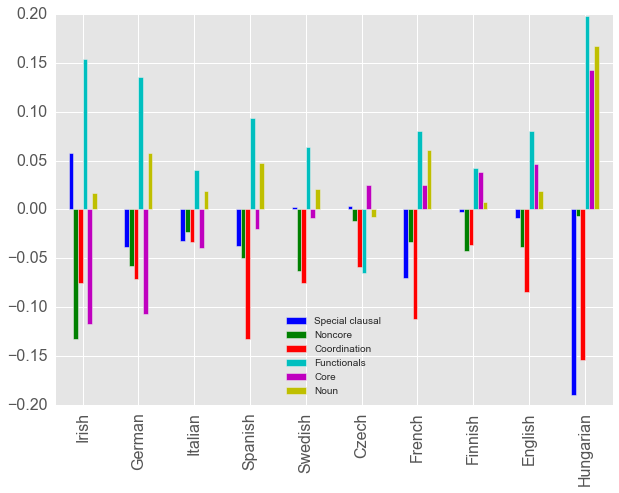

In [32]:
relative_ud_class_result = ud_class_result.subtract(all_labels_results, level=1).xs('precision', level=1, axis=1)
relative_ud_class_result.sort_values('Core').plot(kind='bar', fontsize=16)

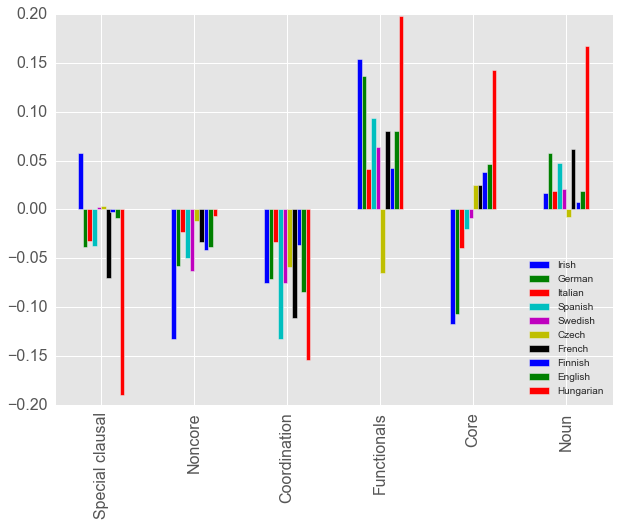

In [33]:
relative_ud_class_result.sort_values("Core").transpose().plot(kind='bar', fontsize=16)

In [34]:
add_order = [('core', dependency_classes.core_dependents),
             ('noncore', dependency_classes.noncore_dependents),
             ('coordination', dependency_classes.coordination_dependents),
             ('special_clausal', dependency_classes.special_clausal_dependents),
             ('noun', dependency_classes.noun_dependents),
             ('other', dependency_classes.other_dependents),
             ('compound_and_unanalyzed', dependency_classes.compound_and_unanalyzed_dependents),
             ('case_marking', dependency_classes.case_marking_dependents),
             ('loose_joining', dependency_classes.loose_joining_dependents)]


labels = []
cumul_results = []
cumul_name = ""
for class_name, label_class in add_order:
    labels += label_class
    labels_result = precision_recall_filter_labels(labels)
    cumul_name = "+" + class_name
    cumul_results.append((cumul_name, labels_result))

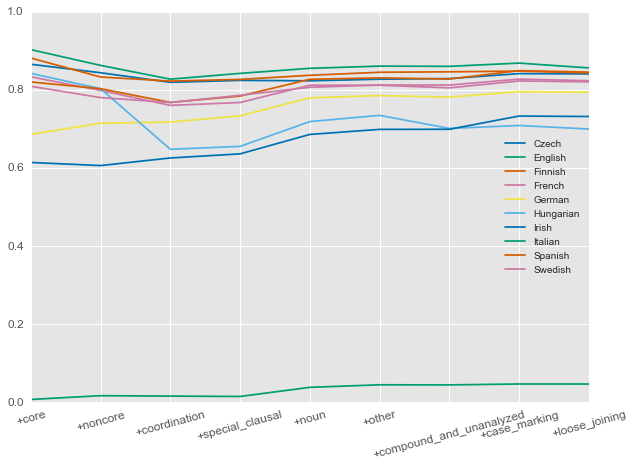

In [35]:
cmap1 = mpl.colors.ListedColormap(sns.color_palette("colorblind", 10))
pd.DataFrame([x[1]['precision'] for x in cumul_results], index=[x[0] for x in cumul_results]).plot(rot=15, fontsize=12, cmap=cmap1)

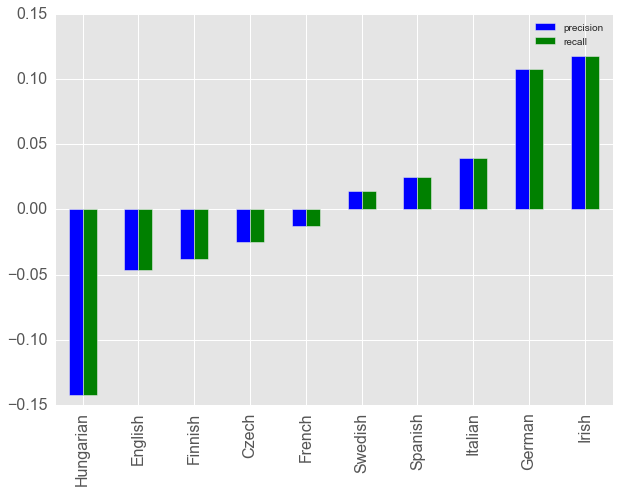

In [36]:
(cumul_results[-1][1] - cumul_results[0][1]).sort_values("precision").plot(kind='bar', fontsize=16)